# 1. Imports

In [63]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# import Compose to compose transforms
from torchvision.transforms import Compose
# plotting
import matplotlib.pyplot as plt

In [64]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


This time, we will also try training the model on GPU.

In [65]:
device

device(type='mps')

# 2. Preparing Data

In this case we use the in-built `MNIST` dataset provided by PyTorch.

In [66]:
# model hyper-parameters
input_size = 28*28
hidden_size = 100
num_classes = 10

# others
batch_size = 100
num_epochs = 5
learning_rate = 0.001

In [67]:
# MNIST dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# train
# keep download=True, the first time
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=ToTensor(),
    download=True
)
'''
train_dataset = MNIST(
    root='./data/MNIST/',
    train=True,
    transform=ToTensor(),
    download=False
)


# test
test_dataset = MNIST(
    root='./data/MNIST/',
    train=False,
    transform=ToTensor()
    # don't have to download again
)

# DataLoader

#train
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

#test
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),
    shuffle=False
)

# extracting the test dataset
X_test, y_test = next(iter(test_loader))
# reshaping the data
X_test = X_test.reshape(-1, 28*28)
# adding to GPU
X_test, y_test = X_test.to(device), y_test.to(device)

# printing info
print("Size of Train Dataset:", len(train_dataset))
print("Size of Test Dataset:", len(test_dataset))

print("Test Shapes:", X_test.shape, y_test.shape)

Size of Train Dataset: 60000
Size of Test Dataset: 10000
Test Shapes: torch.Size([10000, 784]) torch.Size([10000])


We try visualizing a few images from the test dataset.

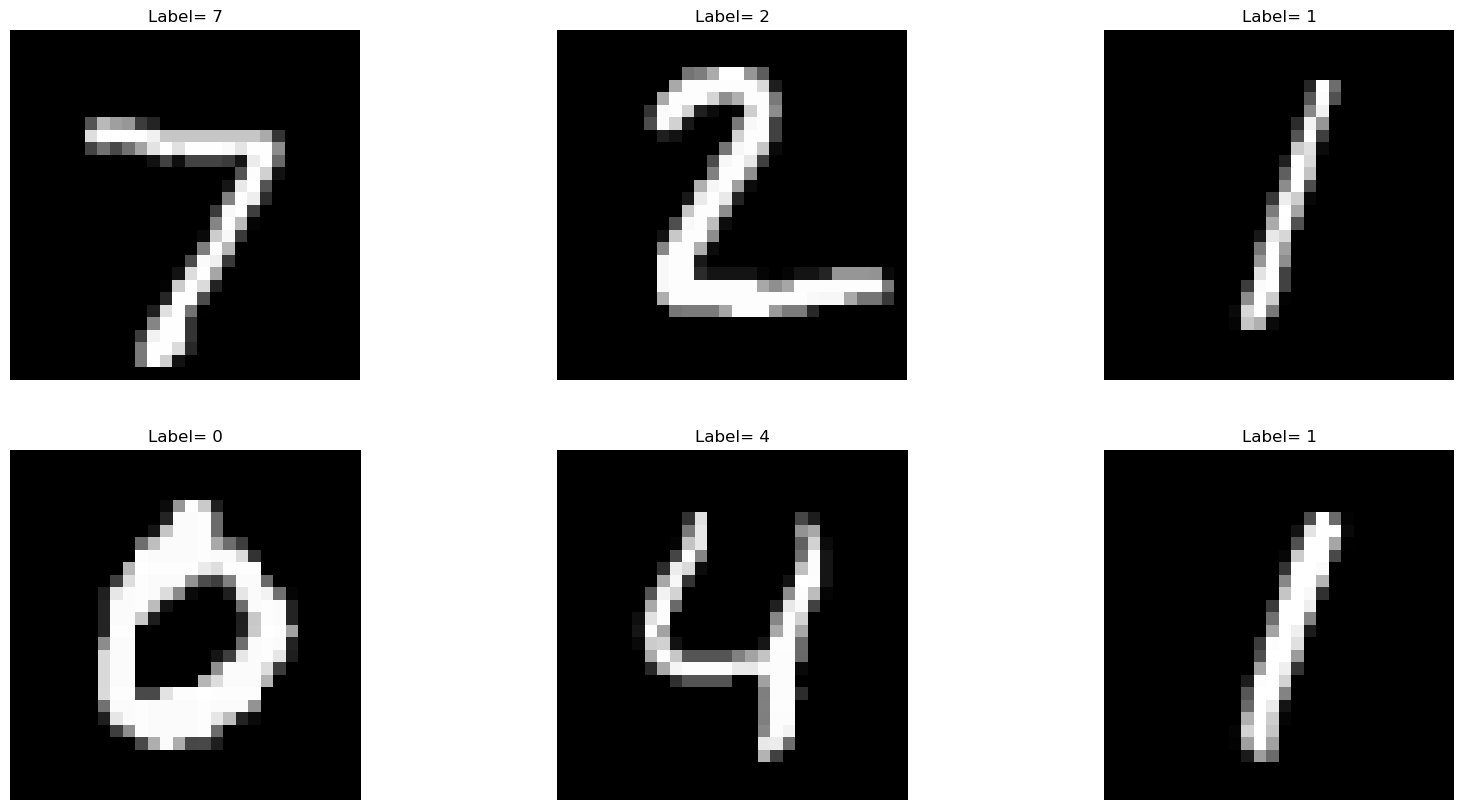

In [78]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Label= " + str(y_test[i].item()))
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Model

We train a fully connected Neural Network with `1` hidden layer with `100` nodes. We will also train this NN on the GPU.

In [69]:
class MNIST_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNIST_NN, self).__init__()

        # extracting the parameters
        self.n_features = input_size
        self.n_classes = num_classes
        
        # defining the layers
        # layer-1
        self.l1 = nn.Linear(input_size, hidden_size)
        self.a1 = nn.ReLU()

        # layer-2
        self.l2 = nn.Linear(hidden_size, num_classes)
        # no softmax activation layer, will be applied by CrossEntropyLoss
    
    def forward(self, X):
        # layer-1
        out = self.a1(self.l1(X))
        # layer-2
        out = self.l2(out)
        # out = self.a2(self.l2(out))
        # no softmax activation layer, will be applied by CrossEntropyLoss

        return out

Let's initialize the mdoel and test the results on the test dataset.

In [70]:
print(input_size, hidden_size, num_classes)

784 100 10


In [71]:
# define the model
model = MNIST_NN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device=device)

In [72]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.1112


# 4. Training

In [73]:
# model hyper-parameters
input_size = 28*28
hidden_size = 100
num_classes = 10

# others
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

In [74]:
# total no. of update steps
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    # load training data in batched via train_loader
    for (idx, batch) in enumerate(train_loader):
        # extract features and labels
        X_train_batch, y_train_batch = batch
        # reshape data
        X_train_batch = X_train_batch.reshape(-1, 28*28)
        # adding the batch to the GPU
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        # training processes
        # forward pass:
        # compute prediction
        y_train_batch_pred = model(X_train_batch)
        # compute loss
        loss = criterion(y_train_batch_pred, y_train_batch)
        # this applies soft-max by itself

        # backward pass:
        # compute gradients
        loss.backward()

        # update weights:
        optimizer.step()
        # zero-gradients after updating
        optimizer.zero_grad()

        # print info after every 100 mini-batches
        if idx%100 == 0:
            print('-------------------------------')
            print(f'Epoch: {epoch+1}/{num_epochs}')
            print(f'Steps: {idx+1}/{n_total_steps}')
            print(f'Loss: {loss.item()}')


-------------------------------
Epoch: 1/5
Steps: 1/600
Loss: 2.3135228157043457
-------------------------------
Epoch: 1/5
Steps: 101/600
Loss: 0.4019440710544586
-------------------------------
Epoch: 1/5
Steps: 201/600
Loss: 0.4629659950733185
-------------------------------
Epoch: 1/5
Steps: 301/600
Loss: 0.15815721452236176
-------------------------------
Epoch: 1/5
Steps: 401/600
Loss: 0.2503645718097687
-------------------------------
Epoch: 1/5
Steps: 501/600
Loss: 0.3130251169204712
-------------------------------
Epoch: 2/5
Steps: 1/600
Loss: 0.19367480278015137
-------------------------------
Epoch: 2/5
Steps: 101/600
Loss: 0.23341289162635803
-------------------------------
Epoch: 2/5
Steps: 201/600
Loss: 0.1696692258119583
-------------------------------
Epoch: 2/5
Steps: 301/600
Loss: 0.12929831445217133
-------------------------------
Epoch: 2/5
Steps: 401/600
Loss: 0.12378758937120438
-------------------------------
Epoch: 2/5
Steps: 501/600
Loss: 0.21300944685935974
--

# 5. Evaluation

In [75]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.9727


Note: The accuracy has improved from `11.12%` to `97.27%`.

We, can also visualize some of the predictions.

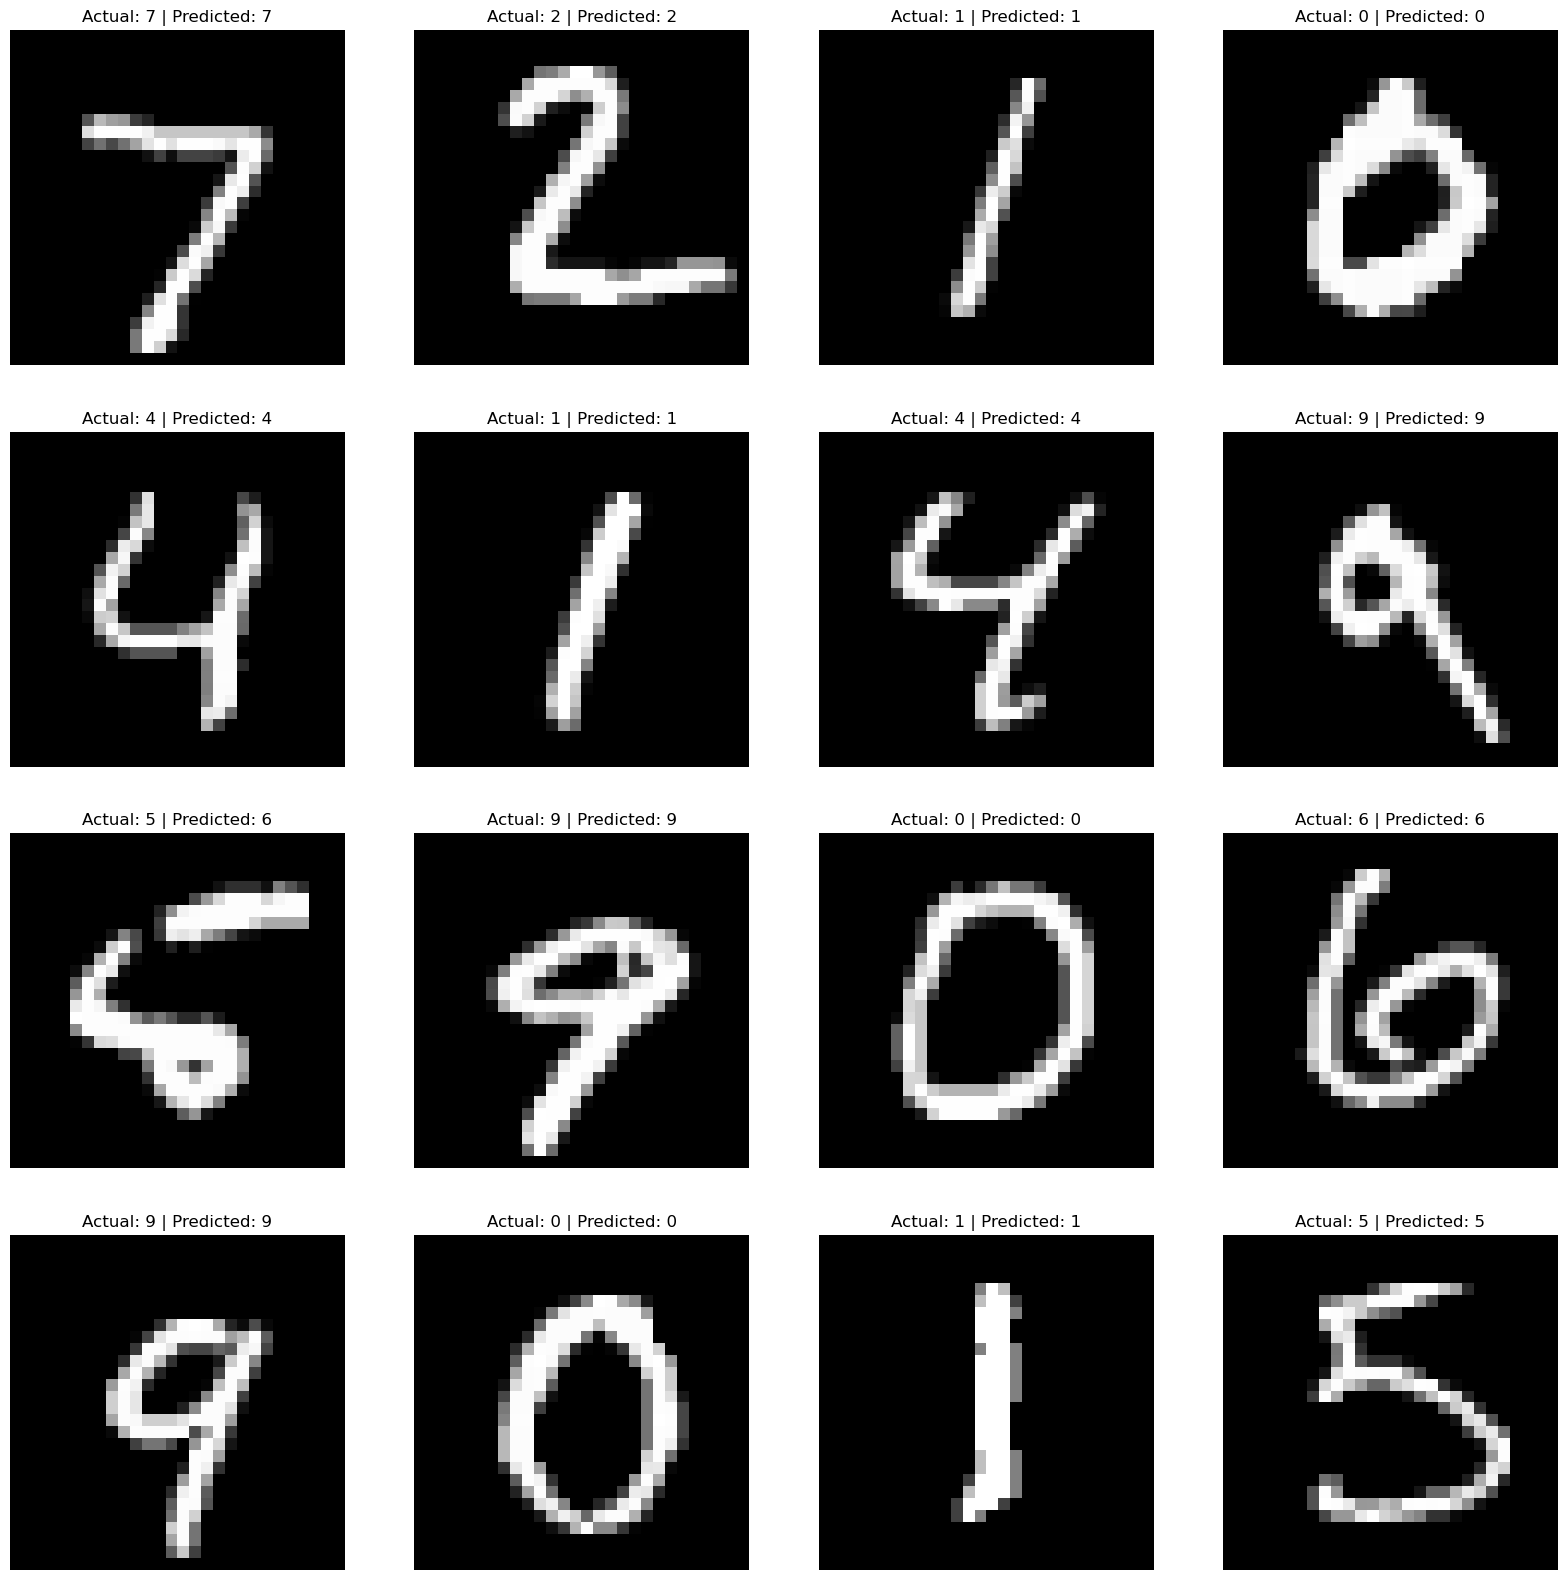

In [76]:
plt.figure(figsize=(20,20))
for i in range(16):
    # prediction
    with torch.no_grad():
        y_pred = model(X_test[i])
        y_hat = torch.argmax(y_pred)
    
    plt.subplot(4, 4, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we only have a single channel image
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title("Actual: " + str(y_test[i].item()) + " | Predicted: " + str(y_hat.item()))
    plt.grid(False)
    plt.axis(False)
plt.show()

As we can see, this is fairly good at identifying the handwritten images.